In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from datetime import datetime
import json
import ast
from sklearn.model_selection import train_test_split
import pickle

tqdm().pandas()

<ipython-input-1-f589b317590f>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# data_folder = 'F:\\Projects\\train\\episerver\\data\\rs\\'
data_folder = 'E:\\Projects\\Train\\episerver\\data\\rs\\'
model_folder = 'E:\\Projects\\Train\\episerver\\model\\rs\\'

In [45]:
movies_metadata = pd.read_csv(data_folder + 'movies_metadata.csv')
keywords = pd.read_csv(data_folder + 'keywords.csv')
credits = pd.read_csv(data_folder + 'credits.csv')
links = pd.read_csv(data_folder + 'links.csv')
ratings = pd.read_csv(data_folder + 'ratings.csv')

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [42]:
ratings['rating'].mean(), ratings['rating'].std() ** 2

(3.5280903543608817, 1.1351682826487322)

In [43]:
np.sqrt(0.8526)

0.9233634170791044

In [57]:
set(keywords['id']).intersection(set(ratings['movieId'].unique())).__len__()

7565

In [4]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
45838,176269,6209470,439050.0
45839,176271,2028550,111109.0
45840,176273,303758,67758.0
45841,176275,8536,227506.0


In [5]:
movie_agg = ratings.groupby(by='movieId').agg({
    'userId': 'count',
    'rating': 'mean'
})
movie_agg.columns = ['num_ratings', 'rating_mean']
movie_agg = movie_agg.reset_index()

In [9]:
movie_agg = movie_agg.sort_values(by='num_ratings', ascending=True)

In [33]:
movie_agg.tail(30)

,movieId,num_ratings,rating_mean
584,590,51338,3.740689
7042,7153,51837,4.109478
5854,5952,51882,4.079777
602,608,52474,4.105347
46,47,52658,4.068128
31,32,53398,3.888769
586,592,53717,3.384822
1242,1270,54783,3.922549
453,457,56820,3.982462
4898,4993,56827,4.104167


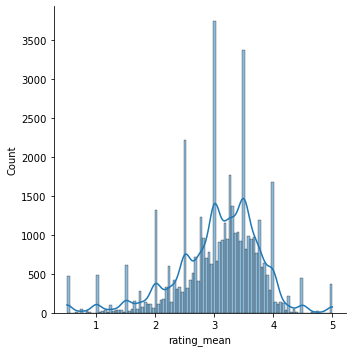

In [39]:
sns.displot(movie_agg['rating_mean'], kde=True)

In [7]:
top_num_ratings_movie = movie_agg.sort_values(by='num_ratings', ascending=False).head(20)['movieId'].values

In [8]:
movies_metadata = movies_metadata[['id', 'release_date', 'title']].copy()
movies_metadata['id'] = movies_metadata['id'].apply(lambda x: -1 if str(x).__contains__('-') else int(x))
movies_metadata['id'] = movies_metadata['id'].astype(np.int64)

In [9]:
movies_metadata[movies_metadata['id'].isin(top_num_ratings_movie)]

,id,release_date,title
286,527,1994-09-02,Once Were Warriors
302,110,1994-05-27,Three Colors: Red
534,858,1993-06-24,Sleepless in Seattle
938,260,1935-06-01,The 39 Steps
3382,593,1972-03-20,Solaris
4020,318,2000-02-09,The Million Dollar Hotel
4919,150,1982-12-07,48 Hrs.
5004,480,2001-08-30,Monsoon Wedding
6388,296,2003-07-02,Terminator 3: Rise of the Machines
6833,780,1928-04-21,The Passion of Joan of Arc


In [10]:
movies_metadata

,id,release_date,title
0,862,1995-10-30,Toy Story
1,8844,1995-12-15,Jumanji
2,15602,1995-12-22,Grumpier Old Men
3,31357,1995-12-22,Waiting to Exhale
4,11862,1995-02-10,Father of the Bride Part II
...,...,...,...
45461,439050,NaN,Subdue
45462,111109,2011-11-17,Century of Birthing
45463,67758,2003-08-01,Betrayal
45464,227506,1917-10-21,Satan Triumphant


In [58]:
meta_data = pickle.load(open(model_folder + 'meta_data.pkl', 'rb'))

In [59]:
meta_data

{'num_users': 270896,
 'num_items': 45115,
 'num_keywords': 8265,
 'mu': 3.528004970570228}

### preprocess rating

In [22]:
ratings.shape, ratings['userId'].unique().__len__(), ratings['movieId'].unique().__len__()

((26024289, 4), 270896, 45115)

In [23]:
USER_MIN_NUM_ITEMS = 3
ITEM_MIN_NUM_USERS = 3

In [24]:
user_item_count = ratings['userId'].value_counts()
item_user_count = ratings['movieId'].value_counts()

In [25]:
sparse_users = list(user_item_count[user_item_count < USER_MIN_NUM_ITEMS].index)
sparse_items = list(item_user_count[item_user_count < ITEM_MIN_NUM_USERS].index)

In [26]:
sparse_users.__len__(), sparse_items.__len__()

(8693, 12628)

In [27]:
user_agg = ratings.groupby(by='userId').agg({
    'movieId': 'count'
}).reset_index()
user_agg.columns = ['userId', 'num_ratings']

In [28]:
user_agg[user_agg['num_ratings'] < 10].shape

(36993, 2)

In [29]:
user_agg.shape

(270896, 2)

In [30]:
10/45000

0.00022222222222222223

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


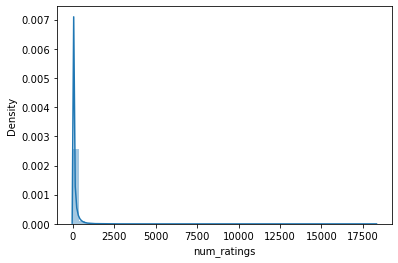

In [31]:
sns.distplot(user_agg['num_ratings'])
# user_agg

In [32]:
item_rated_by_sparse_users = ratings[ratings['userId'].isin(sparse_users)]['movieId'].unique()
set(item_rated_by_sparse_users).intersection(set(sparse_items)).__len__()

11

#### notes:
    - only 2 movives is rated by one user, and that user only rates one movice
    - only 11 movives is rated by users who only rates less than 3 movive
    - --> don't need to process sparsity

### preprocess keywords

In [5]:
MIN_OCCURRED_KEYWORD = 3


def get_all_keywords(keywords):
    all_keywords = dict()
    for keyword in keywords['keywords']:
        list_keywords = ast.literal_eval(keyword)
        if list_keywords.__len__() > 0:
            for keyword_info in list_keywords:
                keyword_value = keyword_info['name']
                if not all_keywords.__contains__(keyword_value):
                    all_keywords[keyword_value] = 0
                all_keywords[keyword_value] += 1
    all_keywords = pd.DataFrame({
        'keyword': list(all_keywords.keys()),
        'num_count': list(all_keywords.values())
    })
    return all_keywords


def get_common_keywords(keyword_df):
    keyword_df = keyword_df.sort_values(by='num_count', ascending=False)
    common_keywords = keyword_df[keyword_df['num_count'] >= MIN_OCCURRED_KEYWORD].keyword
    return common_keywords

In [6]:
all_keywords = get_all_keywords(keywords)

In [11]:
all_keywords = get_all_keywords(keywords)
common_keywords = get_common_keywords(all_keywords)

In [12]:
def get_movie_keyword(common_keywords, keywords):
    map_keywords = {keyword: i + 1 for i, keyword in enumerate(common_keywords)}

    map_movie_keyword = dict()
    for movie_id, keyword in keywords[['id', 'keywords']].values:
        list_keywords = ast.literal_eval(keyword)
        movie_keywords = []
        if list_keywords.__len__() > 0:
            for keyword_info in list_keywords:
                keyword_value = keyword_info['name']
                if map_keywords.__contains__(keyword_value):
                    movie_keywords.append(map_keywords[keyword_value])
        map_movie_keyword[movie_id] = movie_keywords
    movie_keyword_df = pd.DataFrame({
        'movie_id': map_movie_keyword.keys(),
        'keywords': map_movie_keyword.values()
    })

    movie_keyword_df['num_keyword'] = movie_keyword_df['keywords'].apply(lambda x: len(x))
    return movie_keyword_df

In [13]:
movie_keyword_df = get_movie_keyword(common_keywords, keywords)

c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


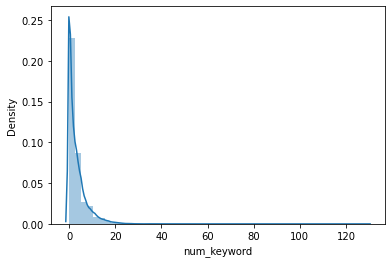

In [14]:
sns.distplot(movie_keyword_df['num_keyword'])

#### padding keyword

In [15]:
MOVIE_MAX_KEYWORD = 15

In [16]:
def padding_keywords(movie_keyword_df, num_pad=MOVIE_MAX_KEYWORD):
    map_padding_keywords = dict()
    for movie_id, keywords in movie_keyword_df[['movie_id', 'keywords']].values:
        if keywords.__len__() < num_pad:
            padding_kewords = np.concatenate([np.array(keywords), np.zeros(num_pad - keywords.__len__())], axis=0).astype(np.int32)
        else:
            padding_kewords = np.array(keywords[:15]).astype(np.int32)
        map_padding_keywords[movie_id] = padding_kewords
    movie_keyword_df['padding_keywords'] = movie_keyword_df['movie_id'].map(map_padding_keywords)
    movie_keyword_df = movie_keyword_df.drop(columns='keywords')
    return movie_keyword_df

In [17]:
movie_keyword_df = padding_keywords(movie_keyword_df)

### mapping movie_id, user_id

In [31]:
all_movie_ids = ratings['movieId'].unique()
movie_id_idx_map = {movie_id: i for i, movie_id in enumerate(all_movie_ids)}
idx_movie_id_map = {idx: movie_id for movie_id, idx in movie_id_idx_map.items()}

In [32]:
def get_all_movie_keywords(all_movie_ids, movie_keyword_df, movie_id_idx_map):
    all_movie_keywords = pd.DataFrame({'movie_id': all_movie_ids})
    all_movie_keywords = all_movie_keywords.merge(movie_keyword_df, how='left', on='movie_id')
    all_movie_keywords['itemId'] = all_movie_keywords['movie_id'].map(movie_id_idx_map)
    all_movie_keywords = all_movie_keywords.sort_values(by='itemId', ascending=True)

    all_movie_keywords['num_keyword'] = all_movie_keywords['num_keyword'].fillna(0)
    all_movie_keywords['num_keyword'] = all_movie_keywords['num_keyword'].astype(np.int32)

    all_movie_keywords.loc[all_movie_keywords['padding_keywords'].isna(), 'padding_keywords'] = str(list(np.zeros(MOVIE_MAX_KEYWORD, dtype=np.int32)))
    all_movie_keywords['padding_keywords'] = all_movie_keywords['padding_keywords'].apply(lambda x: np.array(ast.literal_eval(x)) if type(x) == str else x)

    item_keywords = np.concatenate(all_movie_keywords['padding_keywords'].values, axis=0).reshape(-1, 15)
    return item_keywords

In [34]:
item_keywords = get_all_movie_keywords(all_movie_ids, movie_keyword_df, movie_id_idx_map)

### train test split

In [ ]:
ratings['itemId'] = ratings['movieId'].map(movie_id_idx_map)

In [ ]:
def split_data(ratings):
    ratings = ratings.drop(columns=['timestamp', 'movieId'])
    train, val_test = train_test_split(ratings, test_size=0.1)
    val, test = train_test_split(val_test, test_size=0.5)
    return train, val, test

In [39]:
train, val, test = split_data(ratings)

In [60]:
ratings.shape, train.shape, val.shape, test.shape

((26024289, 3), (23421860, 3), (1301214, 3), (1301215, 3))

In [61]:
set(train['userId'].unique()).intersection(set(val['userId'].unique())).__len__()/val['userId'].unique().__len__(), val['userId'].unique()

(0.9985117596645814,
 array([267098,  85166, 218033, ..., 207247, 108897, 134862], dtype=int64))

In [72]:
pickle.dump(train, open(model_folder + 'train.pkl', 'wb'))
pickle.dump(val, open(model_folder + 'val.pkl', 'wb'))
pickle.dump(test, open(model_folder + 'test.pkl', 'wb'))

pickle.dump(movie_id_idx_map, open(model_folder + 'movie_id_idx_map.pkl', 'wb'))
pickle.dump(idx_movie_id_map, open(model_folder + 'idx_movie_id_map.pkl', 'wb'))
pickle.dump(common_keywords, open(model_folder + 'common_keywords.pkl', 'wb'))
pickle.dump(item_keywords, open(model_folder + 'item_keywords.pkl', 'wb'))

### train

In [80]:
meta_data = {
    'num_users': ratings['userId'].unique().__len__(),
    'num_items':ratings['itemId'].unique().__len__(), 
    'num_keywords': common_keywords.__len__()
}

In [81]:
pickle.dump(meta_data, open(model_folder + 'meta_data.pkl', 'wb'))

In [75]:
common_keywords.__len__()

8265

In [85]:
ratings['userId'].max(), ratings['userId'].min()

(270896, 1)

In [87]:
ratings['userId'].unique().__len__()

270896

In [49]:
item_keywords = pickle.load(open(model_folder + 'item_keywords.pkl', 'rb'))

In [54]:
np.sum(item_keywords.sum(axis=1)==0)

39465

In [55]:
item_keywords.shape

(45115, 15)